### Imports

In [2]:
import sys
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions, estimate_proportions_in_time
import matplotlib.pyplot as plt
import pulp
import pickle
import time

### Data

In [3]:
experiment_name = 'PMG 284 monitoring'

In [4]:
mixture_paths = {
                'Saccharose hydrolysis': '../data/saccharose_hydrolysis/preprocessed_mixture.csv',
                'PMG 284 monitoring': '../data/PMG_284/preprocessed_mixture.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture_cut_to_regions.csv',
                'Saccharose hydrolysis with full mixture spectrum': '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_mixture.csv',
                'PMG 284 monitoring with full mixture spectrum': '../data/PMG_284_full_mixture_spectrum/preprocessed_mixture_whole.csv',
                'PMG 287 monitoring with full mixture spectrum': '../data/PMG_287_full_mixture_spectrum/preprocessed_mixture_whole.csv',
                }

reagents_paths = {
                'Saccharose hydrolysis': ['../data/saccharose_hydrolysis/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_fructose.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_pentene.csv',
                                      '../data/PMG_284/preprocessed_triethylsilane.csv',
                                      '../data/PMG_284/preprocessed_product.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_hexene.csv',
                                      '../data/PMG_287/preprocessed_triethylsilane.csv',
                                      '../data/PMG_287/preprocessed_product.csv'],
                'Saccharose hydrolysis with full mixture spectrum': [
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_fructose.csv'],
                'PMG 284 monitoring with full mixture spectrum' : ['../data/PMG_284_full_mixture_spectrum/preprocessed_pentene.csv',
                                                                  '../data/PMG_284_full_mixture_spectrum/preprocessed_triethylsilane.csv',
                                                                  '../data/PMG_284_full_mixture_spectrum/preprocessed_product.csv'],
    
                'PMG 287 monitoring with full mixture spectrum': ['../data/PMG_287_full_mixture_spectrum/preprocessed_hexene.csv',
                                                                  '../data/PMG_287_full_mixture_spectrum/preprocessed_triethylsilane.csv',
                                                                  '../data/PMG_287_full_mixture_spectrum/preprocessed_product.csv'],
}

mixture_separators = {
                        'Saccharose hydrolysis': '\t',
                        'PMG 284 monitoring': '\t',
                        'PMG 287 monitoring': '\t',
                        'Saccharose hydrolysis with full mixture spectrum': '\t',
                        'PMG 284 monitoring with full mixture spectrum': '\t',
                        'PMG 287 monitoring with full mixture spectrum': '\t'

                        }

reagents_separators = {
                'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t',
                'Saccharose hydrolysis with full mixture spectrum': '\t',
                'PMG 284 monitoring with full mixture spectrum': '\t',
                'PMG 287 monitoring with full mixture spectrum': '\t'
                }

results_paths = {
                'Saccharose hydrolysis': '../results/saccharose_hydrolysis/',
                'PMG 284 monitoring': '../results/PMG_284/',
                'PMG 287 monitoring': '../results/PMG_287/',
                'Saccharose hydrolysis with full mixture spectrum': '../results/saccharose_hydrolysis_full_mixture_spectrum/',
                'PMG 284 monitoring with full mixture spectrum': '../results/PMG_284_full_mixture_spectrum/',
                'PMG 287 monitoring with full mixture spectrum': '../results/PMG_287_full_mixture_spectrum/',
                }

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis' or experiment_name == 'Saccharose hydrolysis with full mixture spectrum':
    ppm = mixture_time_data.iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 284 monitoring' or experiment_name == 'PMG 284 monitoring with full mixture spectrum':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring' or experiment_name == 'PMG 287 monitoring with full mixture spectrum':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [6]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [7]:
mixture_time_data.columns = names

In [8]:
mixture_time_data = np.array(mixture_time_data)

#### Reagents

In [9]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [10]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [11]:
for sp in reagents_spectra:
    sp.trim_negative_intensities()
    sp.normalize()

/home/basia/Documents/spectroscopy/magnetstein/masserstein/spectrum.py:757: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0, ncol=1)


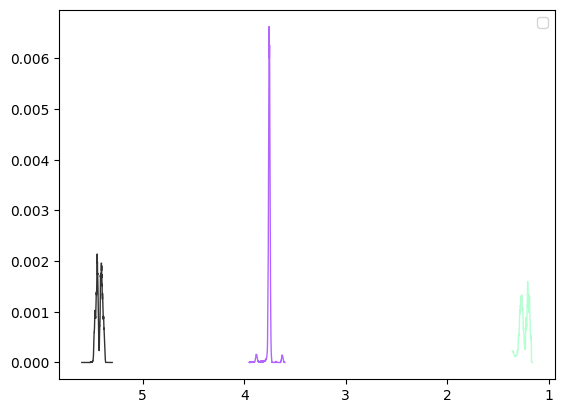

In [12]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all(reagents_spectra, profile=True)

### Estimation

In [13]:
kappa = 0.5
kappa_th = 0.5

In [14]:
import time

In [15]:
start = time.time()
est = estimate_proportions_in_time(mixture_time_data, reagents_spectra, what_to_compare='area', MTD=kappa,
                                    MTD_th=kappa_th, verbose=True, solver=pulp.GUROBI(msg=True, warmStart=False))
end = time.time()

Analyzing timepoint 0.

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(1.16005, 1.3599, 2), (3.60002, 3.94998, 1), (5.30005, 5.5999, 0)]
Number of chunks: 3
ChunkIDs: [2, 1, 0]
Chunk bounds: [(0.66005, 1.8599), (3.10002, 4.44998), (4.80005, 6.0999)]
Ion currents in chunks: [np.float64(0.05151108326861696), np.float64(0.515186239824677), np.float64(0.43330267690670404)]
Deconvolving chunk 0


/home/basia/myvirtualenv/lib/python3.12/site-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-20
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6574 rows, 1647 columns and 16239 nonzeros
Model fingerprint: 0xe0164597
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [4e-04, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [1e-04, 5e-01]
Presolve removed 3286 rows and 0 columns
Presolve time: 0.69s
Presolved: 3288 rows, 3289 columns, 12955 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   5.000000e-01   0.000000e+00      1s
    1663   -4.8884038e-01   0.000000e+00   0.000000e+00      4s

Solved in 1663 iterations and 4.00 seconds (0.37 work units)
Optimal objective -4.88840

/home/basia/Documents/spectroscopy/magnetstein/masserstein/deconv_simplex.py:651: UserWarning: In dualdeconv4:
                Proportions of signal and noise sum to 6.366180 instead of 1.
                This may indicate improper results.
                Please check the deconvolution results and consider reporting this warning to the authors.
                                    
  warn("""In dualdeconv4:


Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 1.0
Noise proportion in mixture's spectrum: 5.366180002929
Total explanation: 6.366180002929
Noise proportion in combination of components' spectra: -0.0
Deconvolving chunk 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 27946 rows, 6997 columns and 67008 nonzeros
Coefficient statistics:
  Matrix range     [8e-09, 1e+00]
  Objective range  [8e-09, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [1e-04, 5e-01]
LP warm-start: use basis

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    2270      handle free variables                          5s
    3286   -1.2081143e+00   2.723656e+02 

Proportions:

[0.5694449323137467, 0.38452383630528447, 0.04603123138097057]


Analyzing timepoint 238.

Proportions:

[0.5700987237296425, 0.38533276120430626, 0.04456851506605259]


Analyzing timepoint 239.

Proportions:

[0.5688446331922766, 0.3847329415908265, 0.04642242521689827]


Analyzing timepoint 240.

Proportions:

[0.568878122591085, 0.38539712789663716, 0.04572474951227922]


Analyzing timepoint 241.

Proportions:

[0.5701437881217212, 0.38523940999271916, 0.04461680188556131]


Analyzing timepoint 242.

Proportions:

[0.5692635755144976, 0.3846929483144947, 0.04604347617100945]


Analyzing timepoint 243.

Proportions:

[0.5687566962506321, 0.3839375918017098, 0.047305711947657716]


Analyzing timepoint 244.

Proportions:

[0.5686731395828459, 0.38457829774830726, 0.0467485626688443]


Analyzing timepoint 245.

Proportions:

[0.5695404510046022, 0.3848878212209139, 0.045571727774482367]


Analyzing timepoint 246.

Proportions:

[0.5679929363402663, 0.3846231373283327, 0.04

Proportions:

[0.5619712359167517, 0.38489156063319147, 0.05313720345005654]


Analyzing timepoint 317.

Proportions:

[0.5607161784833794, 0.38300371293861035, 0.056280108578010954]


Analyzing timepoint 318.

Proportions:

[0.561804233828266, 0.38427585093029704, 0.05391991524143828]


Analyzing timepoint 319.

Proportions:

[0.5611597012486825, 0.38300582241515585, 0.0558344763361624]


Analyzing timepoint 320.

Proportions:

[0.5623457343078847, 0.38400508253107984, 0.053649183161036486]


Analyzing timepoint 321.

Proportions:

[0.5628040992361997, 0.3844590287830035, 0.05273687198079714]


Analyzing timepoint 322.

Proportions:

[0.5620019664794301, 0.3844455503429709, 0.05355248317759861]


Analyzing timepoint 323.

Proportions:

[0.5624499275883039, 0.38449888154782974, 0.05305119086386423]


Analyzing timepoint 324.

Proportions:

[0.5619281253808378, 0.38258293272597554, 0.05548894189318827]


Analyzing timepoint 325.

Proportions:

[0.561274061290397, 0.38286793095782584, 0.

Proportions:

[0.5529740965658779, 0.3824748563261123, 0.06455104710800996]


Analyzing timepoint 396.

Proportions:

[0.5523673533137927, 0.38210777184209294, 0.0655248748441132]


Analyzing timepoint 397.

Proportions:

[0.5523118977195147, 0.3811550215683493, 0.06653308071213776]


Analyzing timepoint 398.

Proportions:

[0.5526920947055828, 0.3819988809758735, 0.06530902431854241]


Analyzing timepoint 399.

Proportions:

[0.5528831578933048, 0.38353907655482394, 0.06357776555187172]


Analyzing timepoint 400.

Proportions:

[0.5523440219592293, 0.3826162946847765, 0.06503968335599467]


Analyzing timepoint 401.

Proportions:

[0.5510001488715429, 0.3815584716601458, 0.06744137946830991]


Analyzing timepoint 402.

Proportions:

[0.5509869479725064, 0.381846493158678, 0.06716655886881691]


Analyzing timepoint 403.

Proportions:

[0.5510183718608693, 0.38242529616253007, 0.06655633197659969]


Analyzing timepoint 404.

Proportions:

[0.5510036763207249, 0.38297969089626177, 0.06601

Proportions:

[0.5365302517412811, 0.3818892474139659, 0.08158050084475285]


Analyzing timepoint 475.

Proportions:

[0.534926838818434, 0.3808583162787199, 0.08421484490284531]


Analyzing timepoint 476.

Proportions:

[0.5344275250912494, 0.382038513544834, 0.08353396136391526]


Analyzing timepoint 477.

Proportions:

[0.5348310252701878, 0.38215396567888493, 0.08301500905092729]


Analyzing timepoint 478.

Proportions:

[0.5345135676382752, 0.38120763221416953, 0.08427880014755788]


Analyzing timepoint 479.

Proportions:

[0.5334626382525488, 0.3808995381738817, 0.08563782357356924]


Analyzing timepoint 480.

Proportions:

[0.5332598911154043, 0.38185847754236957, 0.08488163134222597]


Analyzing timepoint 481.

Proportions:

[0.5335186974360904, 0.38344847649568164, 0.08303282606822925]


Analyzing timepoint 482.

Proportions:

[0.5325392660367528, 0.3822425847558473, 0.08521814920739977]


Analyzing timepoint 483.

Proportions:

[0.5334119724055714, 0.3827797931500112, 0.08380

Proportions:

[0.4984170561808938, 0.3743890703444622, 0.12719387347464325]


Analyzing timepoint 554.

Proportions:

[0.4984503953947541, 0.37431155495224916, 0.127238049652996]


Analyzing timepoint 555.

Proportions:

[0.4985006661851293, 0.37401797995601715, 0.1274813538588536]


Analyzing timepoint 556.

Proportions:

[0.4984576468753442, 0.3731743114579312, 0.12836804166672533]


Analyzing timepoint 557.

Proportions:

[0.49643677033474387, 0.3720942297153068, 0.1314689999499494]


Analyzing timepoint 558.

Proportions:

[0.497163721876145, 0.37407044147288404, 0.12876583665097066]


Analyzing timepoint 559.

Proportions:

[0.49631235213854097, 0.37298466315324125, 0.13070298470821728]


Analyzing timepoint 560.

Proportions:

[0.4960355852436429, 0.3722790148407412, 0.1316853999156157]


Analyzing timepoint 561.

Proportions:

[0.4965773055981736, 0.3747496318832021, 0.12867306251862404]


Analyzing timepoint 562.

Proportions:

[0.49500722300612526, 0.3717887752489538, 0.133204

Proportions:

[0.4672952319481348, 0.36117399352461543, 0.17153077452725052]


Analyzing timepoint 633.

Proportions:

[0.46771166973987155, 0.3629846619762453, 0.16930366828388374]


Analyzing timepoint 634.

Proportions:

[0.4651335330252954, 0.3624373268157488, 0.17242914015895616]


Analyzing timepoint 635.

Proportions:

[0.4650099324841772, 0.36241129713068004, 0.1725787703851423]


Analyzing timepoint 636.

Proportions:

[0.4657698781019004, 0.3620826277632339, 0.17214749413486546]


Analyzing timepoint 637.

Proportions:

[0.4661690633314873, 0.36234834382687764, 0.17148259284163478]


Analyzing timepoint 638.

Proportions:

[0.4664092945606496, 0.3617240338189869, 0.17186667162036337]


Analyzing timepoint 639.

Proportions:

[0.46400441757682465, 0.35975985780775366, 0.17623572461542236]


Analyzing timepoint 640.

Proportions:

[0.46493490824531375, 0.36380074441114224, 0.17126434734354437]


Analyzing timepoint 641.

Proportions:

[0.4623441500437851, 0.36068187904558, 0.17

Proportions:

[0.4430652466425775, 0.35115208992392405, 0.20578266343349855]


Analyzing timepoint 712.

Proportions:

[0.44575755381194604, 0.35338133792329046, 0.2008611082647628]


Analyzing timepoint 713.

Proportions:

[0.4474286042929389, 0.3531756776459195, 0.1993957180611433]


Analyzing timepoint 714.

Proportions:

[0.44956336748375814, 0.35603345476244447, 0.19440317775379834]


Analyzing timepoint 715.

Proportions:

[0.449413255319104, 0.355147872052942, 0.19543887262795437]


Analyzing timepoint 716.

Proportions:

[0.44945404526171806, 0.3563053376933781, 0.19424061704490275]


Analyzing timepoint 717.

Proportions:

[0.4491273223242211, 0.35516289935239537, 0.19570977832338426]


Analyzing timepoint 718.

Proportions:

[0.44971385524837165, 0.3558727524448811, 0.19441339230674812]


Analyzing timepoint 719.

Proportions:

[0.44266524559985526, 0.35064628451739055, 0.20668846988275452]


Analyzing timepoint 720.

Proportions:

[0.4454939569036492, 0.35193091496333023, 0.

Proportions:

[0.4370171454978465, 0.3451763410569641, 0.21780651344518995]


Analyzing timepoint 791.

Proportions:

[0.4356540599580468, 0.341794118176837, 0.22255182186511605]


Analyzing timepoint 792.

Proportions:

[0.4363540671655252, 0.34378696977007395, 0.21985896306439925]


Analyzing timepoint 793.

Proportions:

[0.4371193937268894, 0.343192762610216, 0.21968784366289418]


Analyzing timepoint 794.

Proportions:

[0.434079190249056, 0.3408744376072461, 0.22504637214369907]


Analyzing timepoint 795.

Proportions:

[0.43504620210280964, 0.34223204214114344, 0.2227217557560475]


Analyzing timepoint 796.

Proportions:

[0.4400490204871829, 0.3454508288004055, 0.21450015071241163]


Analyzing timepoint 797.

Proportions:

[0.43595917526800804, 0.3424910071660368, 0.22154981756595477]


Analyzing timepoint 798.

Proportions:

[0.4355646145901572, 0.34234092211096456, 0.222094463298879]


Analyzing timepoint 799.

Proportions:

[0.43910160575077994, 0.34544289578572357, 0.215455

Proportions:

[0.4245323100184637, 0.33338884370800287, 0.24207884627353216]


Analyzing timepoint 870.

Proportions:

[0.4292911034713003, 0.33853416293019856, 0.23217473359850124]


Analyzing timepoint 871.

Proportions:

[0.42979058657814884, 0.33870679046556584, 0.2315026229562849]


Analyzing timepoint 872.

Proportions:

[0.43100852808559154, 0.33920898024516877, 0.2297824916692399]


Analyzing timepoint 873.

Proportions:

[0.43247680469431043, 0.3423043612877612, 0.22521883401792817]


Analyzing timepoint 874.

Proportions:

[0.43189021983425796, 0.340036947940226, 0.22807283222551547]


Analyzing timepoint 875.

Proportions:

[0.4312758578315716, 0.3396852224024151, 0.2290389197660138]


Analyzing timepoint 876.

Proportions:

[0.428220459639269, 0.33717493651182273, 0.234604603848908]


Analyzing timepoint 877.

Proportions:

[0.42410187262454935, 0.3325996970030327, 0.24329843037241689]


Analyzing timepoint 878.

Proportions:

[0.42651613447179054, 0.3357491488228342, 0.237

Proportions:

[0.415917918760391, 0.32979208510914393, 0.2542899961304646]


Analyzing timepoint 949.

Proportions:

[0.42085893067339497, 0.33644129545343665, 0.24269977387316768]


Analyzing timepoint 950.

Proportions:

[0.42183677758709154, 0.33559259422696786, 0.24257062818594094]


Analyzing timepoint 951.

Proportions:

[0.41989819739169515, 0.33463191973991036, 0.245469882868395]


Analyzing timepoint 952.

Proportions:

[0.41824980337424733, 0.3333040746607855, 0.24844612196496751]


Analyzing timepoint 953.

Proportions:

[0.41738102236188346, 0.332574383407254, 0.25004459423086206]


Analyzing timepoint 954.

Proportions:

[0.4178677648378834, 0.3332896062957222, 0.24884262886639427]


Analyzing timepoint 955.

Proportions:

[0.4232521485337883, 0.3382237593480882, 0.2385240921181242]


Analyzing timepoint 956.

Proportions:

[0.4258133632267209, 0.3407725999892623, 0.2334140367840162]


Analyzing timepoint 957.

Proportions:

[0.4239391410548123, 0.33919260845582366, 0.2368

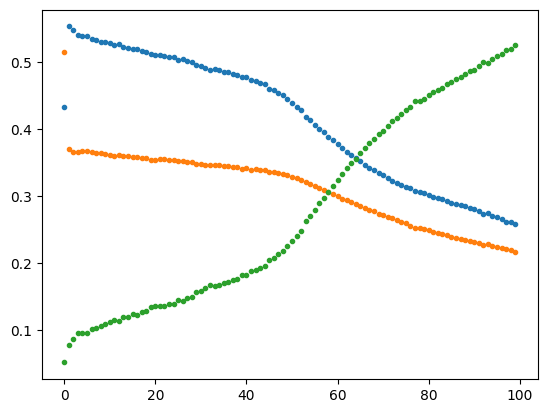

In [17]:
for i in range(3):
    plt.plot(range(len(est['proportions_in_time'])), np.array(est['proportions_in_time'])[:,i], '.')

In [18]:
with open('proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(est['proportions_in_time'], f)